In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from numpy import * ;
import pandas as pd
import numpy as np
import scipy.linalg
import os
import tensorflow as tf
import scipy.optimize as opt

# print(tf.__version__)

In [2]:

def load_csv(path):
    data_read = pd.read_csv(path)
    print(data_read.describe()) #查看数据特征
    list = data_read.values.tolist()
    data = np.array(list)
    print(data.shape)
    # print(data)
    return data

In [3]:
file = "telco.csv"
telco = load_csv(file)
print(telco[1])
# print(telco.description)

          region       tenure          age      marital      address  \
count  1000.0000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      2.0220    35.526000    41.684000     0.495000    11.551000   
std       0.8162    21.359812    12.558816     0.500225    10.086681   
min       1.0000     1.000000    18.000000     0.000000     0.000000   
25%       1.0000    17.000000    32.000000     0.000000     3.000000   
50%       2.0000    34.000000    40.000000     0.000000     9.000000   
75%       3.0000    54.000000    51.000000     1.000000    18.000000   
max       3.0000    72.000000    77.000000     1.000000    55.000000   

            income           ed       employ       retire       gender  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean     77.535000     2.671000    10.987000     0.047000     0.517000  ...   
std     107.044165     1.222397    10.082087     0.211745     0.499961  ...   
min       9.000000     1.000000    

缺失值处理方法, 这里采用 删除https://cloud.tencent.com/developer/article/1680427

In [4]:
y_data = np.c_[telco[:,41]]
x_rows = y_data.shape[0]
x_data = np.c_[telco[:,0:35],telco[:,39:41]]
x_data = np.c_[np.ones((x_rows,1)),x_data] # 矩阵拼接https://blog.csdn.net/ljxopencv/article/details/90548414 

x_cols = x_data.shape[1]
print(x_data[1],x_data.shape,y_data.shape)

[  1.         3.        11.        33.         1.         7.
 136.         5.         5.         0.         0.         6.
   1.         0.         1.         1.         4.4       20.75
   0.        15.25      35.7       42.       211.45       0.
 125.       380.35       0.         1.         1.         0.
   1.         1.         1.         1.         0.         1.481605
   4.912655   4.      ] (1000, 38) (1000, 1)


In [5]:
# 区间变换,[0,100]化为[-1,1] 归一化 后面运行后发现cost变大, 想起来做个归一化会好一些 到时候可以写成函数重复利用率高一点
for i in range(1,38):
    x_data[:,i] = (x_data[:,i] -x_data[:,i].min())/(x_data[:,i].max()-x_data[:,i].min())
print(x_data[1],x_data.shape,y_data.shape)

[1.         1.         0.14084507 0.25423729 1.         0.12727273
 0.07655214 1.         0.10638298 0.         0.         0.71428571
 1.         0.         1.         1.         0.03533569 0.1199422
 0.         0.1395881  0.31889236 0.00566373 0.03574206 0.
 0.0166334  0.04840999 0.         1.         1.         0.
 1.         1.         1.         1.         0.         0.33693324
 0.51998255 1.        ] (1000, 38) (1000, 1)


分出训练集和测试集, 那个valid集还不清楚是干什么的好像是训练过程中验证用的?

In [6]:

mid = (int)(x_rows/2)
x_train = x_data[0:mid,:]
y_train = y_data[0:mid,:]
x_test = x_data[mid:x_rows]
y_test = y_data[mid:x_rows]

sigmoid 函数和 偏差值计算函数 定义

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
#z = X*theta.T 
#z = X*theta.T > 0 g(z) = hθ(x) >= 0.5  y = 1
#z = X*theta.T > 0 g(z) = hθ(x) <  0.5  y = 0

#简化
#X*theta.T >= 0   y = 1
#X*theta.T <  0   y = 0


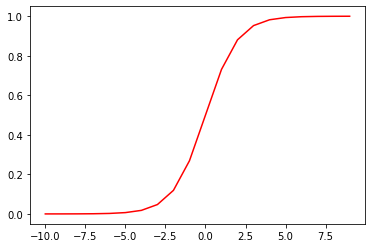

In [8]:
# 测试一下，保证Sigmoid函数正确性
x1 = np.arange(-10, 10, 1)
plt.plot(x1, sigmoid(x1), c='r')
# plt.show()


In [9]:
def computeCostLogis(X,y,theta):
    # 求偏差
    m = len(y) 
#     inner = np.power(((X.dot(theta)) - y), 2) # (pred - y)^2
#     print(X.shape,theta.shape,y.shape)
#     print(y.shape)
#     print(X.dot(theta).shape)
#     print(np.log(sigmoid(X.dot(theta))).shape)
#     print((1-y).shape)
#     print(m)
#     print(inner.shape)
    inner = y.T.dot(np.log(sigmoid(X.dot(theta))))+ (1-y).T.dot(np.log(1-sigmoid(X.dot(theta))))
    return  -1*np.sum(inner)/m;

# # 2)Cost Fuc
# def cost( X, y,theta):
#     first = (-y) * np.log(sigmoid(X @ theta))
#     second = (1 - y)*np.log(1 - sigmoid(X @ theta))
#     return np.mean(first - second)


小测试

In [10]:
theta = np.zeros((x_cols,1))
print(theta.shape,x_data[0])

(38, 1) [1.         0.5        0.16901408 0.44067797 1.         0.16363636
 0.0331525  0.75       0.10638298 0.         0.         0.14285714
 0.         0.         1.         0.         0.02826855 0.
 0.         0.06864989 0.         0.00503672 0.         0.
 0.01463739 0.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.30014537
 0.3756414  0.        ]


In [11]:

cost = computeCostLogis(x_data,y_data,theta)
print(cost.shape)
print(cost)

()
0.6931471805599446


假设函数 
梯度下降函数
的定义


In [13]:
def hypothesis(z):
    return sigmoid(z);# 3)Gradient Fuc
'''
batch gradient descent
转为向量化计算
'''


def gradient(X, y,theta):
    # the gradient of the cost is a vector of the same length as θ where the jth element (for j = 0, 1, . . . , n)
    return (X.T @ (hypothesis(X @ theta) - y)) / len(X)
# @相当于.dot()

def gradientDescent(X, y, theta, learning_rate, num_iters, tol,print_step):
    #参数说明: X数据, y预测目标值, theta参数,learinig_rate 学习率  num_iters迭代次数 tol精度(0.01)
    m = len(y)
    J_history = np.zeros((num_iters, 1))
    Grad_hist = np.zeros((num_iters, 1))

    for i in range(num_iters):
        n = len(theta)
        theta_temp = theta
#         print((X.dot(theta)-y).shape)
#         print(X[:,1].shape)
#         print(X.shape,theta.shape,(X.dot(theta)-y).shape,y.shape,sigmoid(X.dot(theta)-y).shape)
        for j in range(n):
            theta_temp[j] = theta[j]+ learning_rate*(y-hypothesis(X.dot(theta))).T.dot(X[:,j])
#             theta_temp[j] = theta[j] - learning_rate/m*(X.dot(theta)-y).T.dot(X[:,j]); 
        theta = theta_temp 
        cost = computeCostLogis(X, y, theta)
        J_history[i] = cost
        grad = np.sum(gradient(X, y,theta))
        Grad_hist[i] = grad
        if(i%print_step==0):
            print('第%d次迭代, cost = %f grad =%f' %(i,cost,grad))
#         if(cost < tol): #如果 cost 小于精确值 则退出
        if(grad < tol): #如果 梯度 小于精确值 则退出
            print('迭代训练结束,迭代次数:%d, 偏差值cost=%f grad =%f'%(i,cost,grad))
            return (theta, i, J_history,Grad_hist)
    
    return (theta,i,J_history,Grad_hist)

In [14]:
X= x_train
y = y_train
learning_rate = 0.001
num_iters = 20000
tol = 0.0001
print_step = 50
theta = np.zeros((x_cols,1))


In [15]:
(theta,iters,J_hist,Grad_hist) = gradientDescent(X, y, theta, learning_rate, num_iters, tol,print_step)

第0次迭代, cost = 0.590294 grad =1.398392
第50次迭代, cost = 0.439701 grad =0.035193
第100次迭代, cost = 0.425830 grad =0.024122
第150次迭代, cost = 0.419714 grad =0.018517
第200次迭代, cost = 0.416041 grad =0.015051
第250次迭代, cost = 0.413512 grad =0.012661
第300次迭代, cost = 0.411641 grad =0.010892
第350次迭代, cost = 0.410187 grad =0.009515
第400次迭代, cost = 0.409017 grad =0.008408
第450次迭代, cost = 0.408049 grad =0.007496
第500次迭代, cost = 0.407228 grad =0.006734
第550次迭代, cost = 0.406519 grad =0.006087
第600次迭代, cost = 0.405898 grad =0.005535
第650次迭代, cost = 0.405348 grad =0.005059
第700次迭代, cost = 0.404854 grad =0.004647
第750次迭代, cost = 0.404408 grad =0.004288
第800次迭代, cost = 0.404003 grad =0.003973
第850次迭代, cost = 0.403632 grad =0.003697
第900次迭代, cost = 0.403291 grad =0.003454
第950次迭代, cost = 0.402975 grad =0.003238
第1000次迭代, cost = 0.402684 grad =0.003046
第1050次迭代, cost = 0.402412 grad =0.002875
第1100次迭代, cost = 0.402159 grad =0.002723
第1150次迭代, cost = 0.401922 grad =0.002586
第1200次迭代, cost = 0.401700 grad =0.00246

第10050次迭代, cost = 0.395174 grad =0.000622
第10100次迭代, cost = 0.395164 grad =0.000620
第10150次迭代, cost = 0.395154 grad =0.000618
第10200次迭代, cost = 0.395144 grad =0.000617
第10250次迭代, cost = 0.395134 grad =0.000615
第10300次迭代, cost = 0.395124 grad =0.000613
第10350次迭代, cost = 0.395114 grad =0.000611
第10400次迭代, cost = 0.395104 grad =0.000609
第10450次迭代, cost = 0.395094 grad =0.000607
第10500次迭代, cost = 0.395085 grad =0.000605
第10550次迭代, cost = 0.395075 grad =0.000604
第10600次迭代, cost = 0.395066 grad =0.000602
第10650次迭代, cost = 0.395056 grad =0.000600
第10700次迭代, cost = 0.395047 grad =0.000598
第10750次迭代, cost = 0.395037 grad =0.000596
第10800次迭代, cost = 0.395028 grad =0.000595
第10850次迭代, cost = 0.395019 grad =0.000593
第10900次迭代, cost = 0.395009 grad =0.000591
第10950次迭代, cost = 0.395000 grad =0.000589
第11000次迭代, cost = 0.394991 grad =0.000588
第11050次迭代, cost = 0.394982 grad =0.000586
第11100次迭代, cost = 0.394973 grad =0.000584
第11150次迭代, cost = 0.394964 grad =0.000583
第11200次迭代, cost = 0.394955 grad =0

第19850次迭代, cost = 0.393866 grad =0.000387
第19900次迭代, cost = 0.393862 grad =0.000386
第19950次迭代, cost = 0.393857 grad =0.000385


测试后发现 第一训练 cost变大, 先加个归一化再说

20000


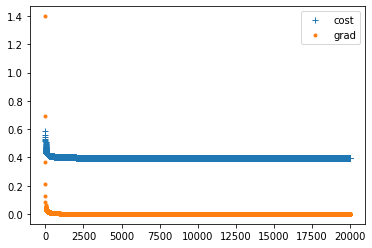

In [16]:
print(J_hist.size)

x_axis = np.linspace(0,iters,iters)
plt.plot(x_axis,J_hist[0:iters],'+')
plt.plot(x_axis,Grad_hist[0:iters],'.')
plt.legend(['cost','grad'])

准确率 70左右

In [17]:

def predict( X,theta):
    probability = sigmoid(X @ theta)
    return [1 if x >= 0.5 else 0 for x in probability]  # return a list


# learning_parameters = np.array([-25.1613186, 0.20623159, 0.20147149])
X = x_test
predictions = predict( X,theta)
print(predictions)
correct = []
for i in range(len(predictions)):
    if predictions[i] == y_test[i]:
        correct.append(1)
    else:
        correct.append(0)
        pass
    pass
# correct = [1 if a == b else 0 for (a, b) in zip(predictions, y)] 这样也可以返回一个list
accuracy = sum(correct)/len(X)
print(accuracy*100)


[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

## 牛顿法

In [18]:
# 学习痕迹  学习python 搞成单位矩阵
X= x_train
y = y_train
learning_rate = 0.001
num_iters = 20000
tol = 0.0001
print_step = 50
theta = np.zeros((x_cols,1))
print(X.shape,theta.shape)
d = hypothesis(X.dot(theta))*(1-hypothesis(X.dot(theta)))
print(d.shape)
D = np.diag(d.flatten())
print(D.shape)
print(D)

(500, 38) (38, 1)
(500, 1)
(500, 500)
[[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]


In [19]:
def newtonsMethod(X, y, theta, learning_rate, num_iters, tol,print_step):
    #参数说明: X数据, y预测目标值, theta参数,learinig_rate 学习率  num_iters迭代次数 tol精度(0.01)
    m = len(y)
    J_history = np.zeros((num_iters, 1))
    Grad_hist = np.zeros((num_iters, 1))

    for i in range(num_iters):
        n = len(theta)
        d = hypothesis(X.dot(theta))*(1-hypothesis(X.dot(theta)))
        D = np.diag(d.flatten())
        H = X.T.dot(D).dot(X)
        grad = gradient(X,y,theta)
        
        theta = theta - np.linalg.pinv(H).dot(grad)
        cost = computeCostLogis(X, y, theta)
        J_history[i] = cost
        grad = np.sum(gradient(X, y,theta))
        Grad_hist[i] = grad
        if(i%print_step==0):
            print('第%d次迭代, cost = %f grad =%f' %(i,cost,grad))
#         if(cost < tol): #如果 cost 小于精确值 则退出
        if(grad < tol): #如果 梯度 小于精确值 则退出
            print('迭代训练结束,迭代次数:%d, 偏差值cost=%f grad =%f'%(i,cost,grad))
            return (theta, i, J_history,Grad_hist)
    
    return (theta,i,J_history,Grad_hist)

In [20]:
X= x_train
y = y_train
learning_rate = 0.001
num_iters = 20000
tol = 0.0001
print_step = 50
theta = np.zeros((x_cols,1))

In [21]:
(theta,iters,J_history,Grad_hist) = newtonsMethod(X, y, theta, learning_rate, num_iters, tol,print_step)

第0次迭代, cost = 0.692217 grad =3.054537
第50次迭代, cost = 0.650031 grad =2.763605
第100次迭代, cost = 0.614932 grad =2.500416
第150次迭代, cost = 0.585352 grad =2.262314
第200次迭代, cost = 0.560174 grad =2.046900
第250次迭代, cost = 0.538573 grad =1.852010
第300次迭代, cost = 0.519927 grad =1.675683
第350次迭代, cost = 0.503751 grad =1.516150
第400次迭代, cost = 0.489666 grad =1.371809
第450次迭代, cost = 0.477363 grad =1.241212
第500次迭代, cost = 0.466594 grad =1.123050
第550次迭代, cost = 0.457153 grad =1.016137
第600次迭代, cost = 0.448866 grad =0.919404
第650次迭代, cost = 0.441589 grad =0.831879
第700次迭代, cost = 0.435197 grad =0.752686
第750次迭代, cost = 0.429583 grad =0.681032
第800次迭代, cost = 0.424656 grad =0.616199
第850次迭代, cost = 0.420333 grad =0.557538
第900次迭代, cost = 0.416544 grad =0.504460
第950次迭代, cost = 0.413226 grad =0.456435
第1000次迭代, cost = 0.410325 grad =0.412982
第1050次迭代, cost = 0.407790 grad =0.373665
第1100次迭代, cost = 0.405578 grad =0.338090
第1150次迭代, cost = 0.403651 grad =0.305902
第1200次迭代, cost = 0.401974 grad =0.27677

20000


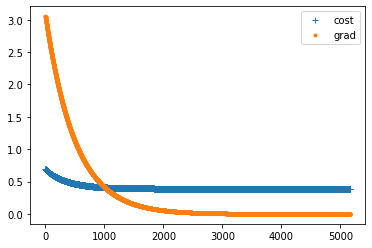

In [22]:
print(J_history.size)

x_axis = np.linspace(0,iters,iters)
plt.plot(x_axis,J_history[0:iters],'+')
plt.plot(x_axis,Grad_hist[0:iters],'.')
plt.legend(['cost','grad'])

In [23]:
def predict( X,theta):
    probability = sigmoid(X.dot(theta))
    return [1 if x >= 0.5 else 0 for x in probability]  # return a list

# learning_parameters = np.array([-25.1613186, 0.20623159, 0.20147149])
X = x_test
predictions = predict( X,theta)
print(predictions)
correct = []
for i in range(len(predictions)):
    if predictions[i] == y_test[i]:
        correct.append(1)
    else:
        correct.append(0)
        pass
    pass
# correct = [1 if a == b else 0 for (a, b) in zip(predictions, y)] 这样也可以返回一个list
accuracy = sum(correct)/len(X)
print(accuracy*100)


[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 

# 加正则化项

In [25]:
Regularization_Parameter = 1

In [29]:
#计算偏差值
def hypothesis(z):
    return sigmoid(z);# 3)Gradient Fuc
'''
batch gradient descent
转为向量化计算
'''

def computeCostLogisReg(X,y,theta,regular):
    # 求偏差
    m = len(y) 
    inner = y.T.dot(np.log(sigmoid(X.dot(theta))))+ (1-y).T.dot(np.log(1-sigmoid(X.dot(theta))))
    inner = inner + Regularization_Parameter*sum(np.power(theta, 2))
    return  -1*np.sum(inner)/m;

def gradient(X, y,theta):
    # the gradient of the cost is a vector of the same length as θ where the jth element (for j = 0, 1, . . . , n)
    return (X.T @ (hypothesis(X @ theta) - y)) / len(X)
# @相当于.dot()

def gradientDescentReg(X, y, theta, learning_rate, num_iters, tol,print_step,Regularization_Parameter):
    #参数说明: X数据, y预测目标值, theta参数,learinig_rate 学习率  num_iters迭代次数 tol精度(0.01)
    m = len(y)
    J_history = np.zeros((num_iters, 1))
    Grad_hist = np.zeros((num_iters, 1))

    for i in range(num_iters):
        n = len(theta)
        theta_temp = theta
#         print((X.dot(theta)-y).shape)
#         print(X[:,1].shape)
#         print(X.shape,theta.shape,(X.dot(theta)-y).shape,y.shape,sigmoid(X.dot(theta)-y).shape)
        for j in range(n):
            theta_temp[j] = theta[j]+ learning_rate*(y-hypothesis(X.dot(theta))).T.dot(X[:,j])
#             theta_temp[j] = theta[j] - learning_rate/m*(X.dot(theta)-y).T.dot(X[:,j]); 
        theta = theta_temp 
        cost = computeCostLogisReg(X, y, theta, Regularization_Parameter )
        J_history[i] = cost
        grad = np.sum(gradient(X, y,theta))
        Grad_hist[i] = grad
        if(i%print_step==0):
            print('第%d次迭代, cost = %f grad =%f' %(i,cost,grad))
#         if(cost < tol): #如果 cost 小于精确值 则退出
        if(grad < tol): #如果 梯度 小于精确值 则退出
            print('迭代训练结束,迭代次数:%d, 偏差值cost=%f grad =%f'%(i,cost,grad))
            return (theta, i, J_history,Grad_hist)
    
    return (theta,i,J_history,Grad_hist)


In [31]:
X= x_train
y = y_train
learning_rate = 0.001
num_iters = 20000
tol = 0.0001
print_step = 50
theta = np.zeros((x_cols,1))


In [32]:
(theta,iters,J_hist,Grad_hist) = gradientDescentReg(X, y, theta, learning_rate, num_iters, tol,print_step,Regularization_Parameter)

第0次迭代, cost = 0.590188 grad =1.398392
第50次迭代, cost = 0.433957 grad =0.035193
第100次迭代, cost = 0.416301 grad =0.024122
第150次迭代, cost = 0.407285 grad =0.018517
第200次迭代, cost = 0.401191 grad =0.015051
第250次迭代, cost = 0.396546 grad =0.012661
第300次迭代, cost = 0.392767 grad =0.010892
第350次迭代, cost = 0.389565 grad =0.009515
第400次迭代, cost = 0.386771 grad =0.008408
第450次迭代, cost = 0.384281 grad =0.007496
第500次迭代, cost = 0.382026 grad =0.006734
第550次迭代, cost = 0.379956 grad =0.006087
第600次迭代, cost = 0.378037 grad =0.005535
第650次迭代, cost = 0.376242 grad =0.005059
第700次迭代, cost = 0.374552 grad =0.004647
第750次迭代, cost = 0.372950 grad =0.004288
第800次迭代, cost = 0.371426 grad =0.003973
第850次迭代, cost = 0.369968 grad =0.003697
第900次迭代, cost = 0.368569 grad =0.003454
第950次迭代, cost = 0.367222 grad =0.003238
第1000次迭代, cost = 0.365923 grad =0.003046
第1050次迭代, cost = 0.364666 grad =0.002875
第1100次迭代, cost = 0.363447 grad =0.002723
第1150次迭代, cost = 0.362264 grad =0.002586
第1200次迭代, cost = 0.361113 grad =0.00246

第10050次迭代, cost = 0.272952 grad =0.000622
第10100次迭代, cost = 0.272618 grad =0.000620
第10150次迭代, cost = 0.272285 grad =0.000618
第10200次迭代, cost = 0.271952 grad =0.000617
第10250次迭代, cost = 0.271619 grad =0.000615
第10300次迭代, cost = 0.271286 grad =0.000613
第10350次迭代, cost = 0.270955 grad =0.000611
第10400次迭代, cost = 0.270623 grad =0.000609
第10450次迭代, cost = 0.270292 grad =0.000607
第10500次迭代, cost = 0.269961 grad =0.000605
第10550次迭代, cost = 0.269631 grad =0.000604
第10600次迭代, cost = 0.269301 grad =0.000602
第10650次迭代, cost = 0.268971 grad =0.000600
第10700次迭代, cost = 0.268642 grad =0.000598
第10750次迭代, cost = 0.268313 grad =0.000596
第10800次迭代, cost = 0.267985 grad =0.000595
第10850次迭代, cost = 0.267657 grad =0.000593
第10900次迭代, cost = 0.267329 grad =0.000591
第10950次迭代, cost = 0.267002 grad =0.000589
第11000次迭代, cost = 0.266675 grad =0.000588
第11050次迭代, cost = 0.266348 grad =0.000586
第11100次迭代, cost = 0.266022 grad =0.000584
第11150次迭代, cost = 0.265696 grad =0.000583
第11200次迭代, cost = 0.265370 grad =0

第19850次迭代, cost = 0.212711 grad =0.000387
第19900次迭代, cost = 0.212423 grad =0.000386
第19950次迭代, cost = 0.212135 grad =0.000385


In [33]:
# learning_parameters = np.array([-25.1613186, 0.20623159, 0.20147149])
X = x_test
predictions = predict( X,theta)
print(predictions)
correct = []
for i in range(len(predictions)):
    if predictions[i] == y_test[i]:
        correct.append(1)
    else:
        correct.append(0)
        pass
    pass
# correct = [1 if a == b else 0 for (a, b) in zip(predictions, y)] 这样也可以返回一个list
accuracy = sum(correct)/len(X)
print(accuracy*100)


[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

#### 加了正则项, 正确率变高了1 cost减少了诶!

2.	对数据的某一列乘上一个很大的数（比如100000），再分别调用梯度下降法与牛顿法计算Logistic回归模型的参数，你有什么发现？

In [34]:


A1 = np.array(x_train, copy=True)
A1[:,2] = A1[:,2]*100000

X= A1
y = y_train
learning_rate = 0.001
num_iters = 20000
tol = 0.0001
print_step = 50
theta = np.zeros((x_cols,1))
(theta,iters,J_hist,Grad_hist) = gradientDescent(X, y, theta, learning_rate, num_iters, tol,print_step)

第0次迭代, cost = nan grad =-7802.958847
迭代训练结束,迭代次数:0, 偏差值cost=nan grad =-7802.958847


C:\Users\sjc\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\sjc\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


20000


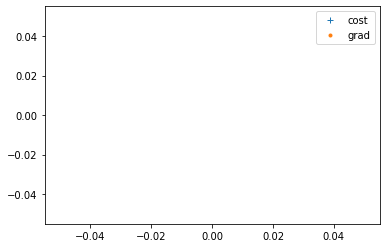

In [35]:
print(J_history.size)

x_axis = np.linspace(0,iters,iters)
plt.plot(x_axis,J_history[0:iters],'+')
plt.plot(x_axis,Grad_hist[0:iters],'.')
plt.legend(['cost','grad'])

In [36]:


A1 = np.array(x_train, copy=True)
A1[:,2] = A1[:,2]*100000

X= A1
y = y_train
learning_rate = 0.001
num_iters = 20000
tol = 0.0001
print_step = 50
theta = np.zeros((x_cols,1))
(theta,iters,J_history,Grad_hist) = newtonsMethod(X, y, theta, learning_rate, num_iters, tol,print_step)

第0次迭代, cost = 0.692217 grad =16905.632030
第50次迭代, cost = 0.650031 grad =15295.448130
第100次迭代, cost = 0.614932 grad =13838.817742
第150次迭代, cost = 0.585352 grad =12521.038841
第200次迭代, cost = 0.560174 grad =11328.836328
第250次迭代, cost = 0.538573 grad =10250.216438
第300次迭代, cost = 0.519927 grad =9274.338884
第350次迭代, cost = 0.503751 grad =8391.403347
第400次迭代, cost = 0.489666 grad =7592.548073
第450次迭代, cost = 0.477363 grad =6869.758905
第500次迭代, cost = 0.466594 grad =6215.787484
第550次迭代, cost = 0.457153 grad =5624.077568
第600次迭代, cost = 0.448866 grad =5088.698582
第650次迭代, cost = 0.441589 grad =4604.285653
第700次迭代, cost = 0.435197 grad =4165.985455
第750次迭代, cost = 0.429583 grad =3769.407289
第800次迭代, cost = 0.424656 grad =3410.578876
第850次迭代, cost = 0.420333 grad =3085.906396
第900次迭代, cost = 0.416544 grad =2792.138368
第950次迭代, cost = 0.413226 grad =2526.332984
第1000次迭代, cost = 0.410325 grad =2285.828580
第1050次迭代, cost = 0.407790 grad =2068.216924
第1100次迭代, cost = 0.405578 grad =1871.319062
第1150

20000
[0.69221706]


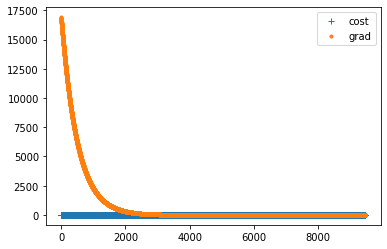

In [39]:
print(J_history.size)

x_axis = np.linspace(0,iters,iters)
plt.plot(x_axis,J_history[0:iters],'+')
print(J_history[0])
plt.plot(x_axis,Grad_hist[0:iters],'.')
plt.legend(['cost','grad'])

### cost 比较小图上看不出来 
梯度下降好像 不行 应该是值太大了 牛顿法可以计算 不过讲道理, 如果先进行归一化的, 也不会有这种问题